# Allergy Prediction Data Processing (Fixed)

This notebook processes genus and metabolite_203 data for allergy prediction (IgE vs. N).
We will:
1. Load genus data and metabolite_203 data
2. Remove samples (nE samples)
3. Merge the datasets based on common samples
4. Prepare data for machine learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load the Data

In [2]:
# Load genus data (this file is tab-separated despite .xls extension)
genus_file = 'DZOE2024090259_售后分析结果.20265.06.27_4cW0iTSH/genus.xls'
genus_data = pd.read_csv(genus_file, sep='\t', index_col=0)

print(f"Genus data shape: {genus_data.shape}")
print(f"Genus data columns (first 10): {list(genus_data.columns[:10])}")
print(f"Genus data index (first 5): {list(genus_data.index[:5])}")

Genus data shape: (567, 374)
Genus data columns (first 10): ['N-4', 'N-5', 'N-12', 'N-13', 'N-16', 'N-18', 'N-19', 'N-24', 'N-26', 'N-28']
Genus data index (first 5): ['Escherichia-Shigella', 'Bifidobacterium', 'Klebsiella', 'Bacteroides', 'Clostridium_sensu_stricto_1']


In [3]:
# Load metabolite_203 data
metabolite_file = '代谢数据/203例代谢/metabolite_203.xlsx'
try:
    # Try with openpyxl engine first (for .xlsx files)
    metabolite_data = pd.read_excel(metabolite_file, index_col=0, engine='openpyxl')
    print("Loaded with openpyxl engine")
except Exception as e:
    print(f"openpyxl failed: {e}")
    try:
        # If openpyxl fails, try xlrd
        metabolite_data = pd.read_excel(metabolite_file, index_col=0, engine='xlrd')
        print("Loaded with xlrd engine")
    except Exception as e2:
        print(f"xlrd also failed: {e2}")
        # Last resort: try reading as tab-separated values
        metabolite_data = pd.read_csv(metabolite_file, sep='\t', index_col=0)
        print("Loaded as tab-separated file")

print(f"Metabolite data shape: {metabolite_data.shape}")
print(f"Metabolite data columns (first 10): {list(metabolite_data.columns[:10])}")
print(f"Metabolite data index (first 5): {list(metabolite_data.index[:5])}")

Loaded with openpyxl engine
Metabolite data shape: (6124, 237)
Metabolite data columns (first 10): ['m/z', 'Retention time (min)', 'Ion mode', 'Metabolites', 'Metabolites_cn', 'cid', 'cidlink', 'HMDB', 'METLIN', 'Lipidmaps']
Metabolite data index (first 5): ['FT03973NR', 'FT11723NR', 'FT01668NR', 'FT03834NR', 'FT09366PR']


## 2. Analyze Sample Names and Labels

In [4]:
# Analyze sample names in genus data
genus_samples = list(genus_data.columns)
print(f"Total genus samples: {len(genus_samples)}")

# Count different sample types
n_samples = [s for s in genus_samples if s.startswith('N-')]
ige_samples = [s for s in genus_samples if s.startswith('IgE-')]
ne_samples = [s for s in genus_samples if s.startswith('nE-')]

print(f"N samples: {len(n_samples)}")
print(f"IgE samples: {len(ige_samples)}")
print(f"nE samples: {len(ne_samples)}")

print(f"\nFirst 5 N samples: {n_samples[:5]}")
print(f"First 5 IgE samples: {ige_samples[:5]}")
print(f"First 5 nE samples: {ne_samples[:5]}")

Total genus samples: 374
N samples: 193
IgE samples: 139
nE samples: 42

First 5 N samples: ['N-4', 'N-5', 'N-12', 'N-13', 'N-16']
First 5 IgE samples: ['IgE-7', 'IgE-14', 'IgE-17', 'IgE-23', 'IgE-27']
First 5 nE samples: ['nE-40', 'nE-61', 'nE-185', 'nE-228', 'nE-347']


In [5]:
# Analyze sample names in metabolite data
metabolite_samples = list(metabolite_data.columns)
print(f"Total metabolite samples: {len(metabolite_samples)}")

# Count different sample types in metabolite data
met_n_samples = [s for s in metabolite_samples if s.startswith('N-')]
met_ige_samples = [s for s in metabolite_samples if s.startswith('IgE-')]
met_ne_samples = [s for s in metabolite_samples if s.startswith('nE-')]

print(f"Metabolite N samples: {len(met_n_samples)}")
print(f"Metabolite IgE samples: {len(met_ige_samples)}")
print(f"Metabolite nE samples: {len(met_ne_samples)}")

print(f"\nFirst 5 metabolite samples: {metabolite_samples[:5]}")

Total metabolite samples: 237
Metabolite N samples: 88
Metabolite IgE samples: 72
Metabolite nE samples: 38

First 5 metabolite samples: ['m/z', 'Retention time (min)', 'Ion mode', 'Metabolites', 'Metabolites_cn']


## 3. Remove nE Samples (Duplicates)

In [6]:
# Remove nE samples from genus data
genus_clean = genus_data.drop(columns=ne_samples)
print(f"Genus data after removing nE samples: {genus_clean.shape}")

# Remove nE samples from metabolite data
metabolite_clean = metabolite_data.drop(columns=met_ne_samples)
print(f"Metabolite data after removing nE samples: {metabolite_clean.shape}")

Genus data after removing nE samples: (567, 332)
Metabolite data after removing nE samples: (6124, 199)


## 4. Find Common Samples Between Datasets

In [7]:
# Find common samples between genus and metabolite data
genus_samples_clean = set(genus_clean.columns)
metabolite_samples_clean = set(metabolite_clean.columns)

common_samples = genus_samples_clean.intersection(metabolite_samples_clean)
print(f"Common samples between datasets: {len(common_samples)}")

# Samples only in genus data
genus_only = genus_samples_clean - metabolite_samples_clean
print(f"Samples only in genus data: {len(genus_only)}")

# Samples only in metabolite data
metabolite_only = metabolite_samples_clean - genus_samples_clean
print(f"Samples only in metabolite data: {len(metabolite_only)}")

print(f"\nFirst 10 common samples: {sorted(list(common_samples))[:10]}")

Common samples between datasets: 160
Samples only in genus data: 172
Samples only in metabolite data: 39

First 10 common samples: ['IgE-100', 'IgE-101', 'IgE-105', 'IgE-110', 'IgE-116', 'IgE-129', 'IgE-135', 'IgE-165', 'IgE-172', 'IgE-174']


## 5. Create Labels for Common Samples

In [8]:
# Create labels for common samples
common_samples_list = sorted(list(common_samples))

# Create label mapping: IgE = 1, N = 0
labels = []
for sample in common_samples_list:
    if sample.startswith('IgE-'):
        labels.append(1)  # Allergy positive
    elif sample.startswith('N-'):
        labels.append(0)  # Allergy negative
    else:
        labels.append(-1)  # Unknown (shouldn't happen after cleaning)

labels_df = pd.DataFrame({
    'sample_id': common_samples_list,
    'label': labels,
    'group': ['IgE' if l == 1 else 'N' for l in labels]
})

print(f"Label distribution:")
print(labels_df['group'].value_counts())
print(f"\nFirst 10 labels:")
print(labels_df.head(10))

Label distribution:
group
N      88
IgE    72
Name: count, dtype: int64

First 10 labels:
  sample_id  label group
0   IgE-100      1   IgE
1   IgE-101      1   IgE
2   IgE-105      1   IgE
3   IgE-110      1   IgE
4   IgE-116      1   IgE
5   IgE-129      1   IgE
6   IgE-135      1   IgE
7   IgE-165      1   IgE
8   IgE-172      1   IgE
9   IgE-174      1   IgE


## 6. Extract Common Samples from Both Datasets

In [9]:
# Extract common samples from genus data
genus_common = genus_clean[common_samples_list].T  # Transpose to have samples as rows
print(f"Genus common samples shape: {genus_common.shape}")

# Extract common samples from metabolite data
metabolite_common = metabolite_clean[common_samples_list].T  # Transpose to have samples as rows
print(f"Metabolite common samples shape: {metabolite_common.shape}")

# Verify sample order is the same
print(f"Sample order matches: {list(genus_common.index) == list(metabolite_common.index)}")

Genus common samples shape: (160, 567)
Metabolite common samples shape: (160, 6124)
Sample order matches: True


## 7. Combine Genus and Metabolite Data

In [10]:
# Combine genus and metabolite data
# Add prefixes to distinguish features
genus_common.columns = ['genus_' + col for col in genus_common.columns]
metabolite_common.columns = ['metabolite_' + col for col in metabolite_common.columns]

# Combine the datasets
combined_data = pd.concat([genus_common, metabolite_common], axis=1)
print(f"Combined data shape: {combined_data.shape}")
print(f"Genus features: {genus_common.shape[1]}")
print(f"Metabolite features: {metabolite_common.shape[1]}")
print(f"Total features: {combined_data.shape[1]}")

Combined data shape: (160, 6691)
Genus features: 567
Metabolite features: 6124
Total features: 6691


## 8. Add Labels to Combined Data

In [11]:
# Add labels to the combined data
combined_data['label'] = labels
combined_data['group'] = [labels_df.loc[labels_df['sample_id'] == idx, 'group'].iloc[0] 
                         for idx in combined_data.index]

print(f"Final combined data shape: {combined_data.shape}")
print(f"\nLabel distribution in final dataset:")
print(combined_data['group'].value_counts())

# Display first few rows
print(f"\nFirst 5 rows of combined data (showing last 5 columns):")
print(combined_data.iloc[:5, -5:])

Final combined data shape: (160, 6693)

Label distribution in final dataset:
group
N      88
IgE    72
Name: count, dtype: int64

First 5 rows of combined data (showing last 5 columns):
         metabolite_FT10487PR  metabolite_FT14461PR  metabolite_FT10795NR  \
IgE-100             40.020247             34.199045             36.781355   
IgE-101             39.162654             43.473145             35.612395   
IgE-105             40.563991             34.199045             37.376721   
IgE-110             31.574599             45.042850             37.689651   
IgE-116             41.708495             37.897923             36.580083   

         label group  
IgE-100      1   IgE  
IgE-101      1   IgE  
IgE-105      1   IgE  
IgE-110      1   IgE  
IgE-116      1   IgE  


## 9. Data Quality Check

In [12]:
# Check for missing values
missing_values = combined_data.isnull().sum()
features_with_missing = missing_values[missing_values > 0]

print(f"Features with missing values: {len(features_with_missing)}")
if len(features_with_missing) > 0:
    print("Features with missing values:")
    print(features_with_missing.head(10))
else:
    print("No missing values found!")

# Check data types
print(f"\nData types:")
print(combined_data.dtypes.value_counts())

Features with missing values: 0
No missing values found!

Data types:
float64    6691
int64         1
object        1
Name: count, dtype: int64


## 10. Save Processed Data

In [13]:
# Save the processed data
# Separate features and labels
X = combined_data.drop(['label', 'group'], axis=1)
y = combined_data['label']
groups = combined_data['group']

# Save to Excel files
X.to_excel('processed_features_genus_metabolite203.xlsx')
labels_df_final = pd.DataFrame({
    'sample_id': combined_data.index,
    'label': y,
    'group': groups
})
labels_df_final.to_excel('processed_labels_genus_metabolite203.xlsx', index=False)

# Save combined data
combined_data.to_excel('processed_combined_genus_metabolite203.xlsx')

print("Data saved successfully!")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Files saved:")
print("- processed_features_genus_metabolite203.xlsx")
print("- processed_labels_genus_metabolite203.xlsx")
print("- processed_combined_genus_metabolite203.xlsx")

Data saved successfully!
Features shape: (160, 6691)
Labels shape: (160,)
Files saved:
- processed_features_genus_metabolite203.xlsx
- processed_labels_genus_metabolite203.xlsx
- processed_combined_genus_metabolite203.xlsx


## 11. Data Summary and Visualization

In [14]:
# Create summary statistics
print("=== DATA PROCESSING SUMMARY ===")
print(f"Original genus data: {genus_data.shape}")
print(f"Original metabolite data: {metabolite_data.shape}")
print(f"nE samples removed from genus: {len(ne_samples)}")
print(f"nE samples removed from metabolite: {len(met_ne_samples)}")
print(f"Common samples between datasets: {len(common_samples)}")
print(f"Final combined dataset: {combined_data.shape}")
print(f"Features: {X.shape[1]} (Genus: {genus_common.shape[1]}, Metabolite: {metabolite_common.shape[1]})")
print(f"Samples: {X.shape[0]}")
print(f"\nClass distribution:")
print(f"IgE (Allergy positive): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")
print(f"N (Allergy negative): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")

=== DATA PROCESSING SUMMARY ===
Original genus data: (567, 374)
Original metabolite data: (6124, 237)
nE samples removed from genus: 42
nE samples removed from metabolite: 38
Common samples between datasets: 160
Final combined dataset: (160, 6693)
Features: 6691 (Genus: 567, Metabolite: 6124)
Samples: 160

Class distribution:
IgE (Allergy positive): 72 (45.0%)
N (Allergy negative): 88 (55.0%)


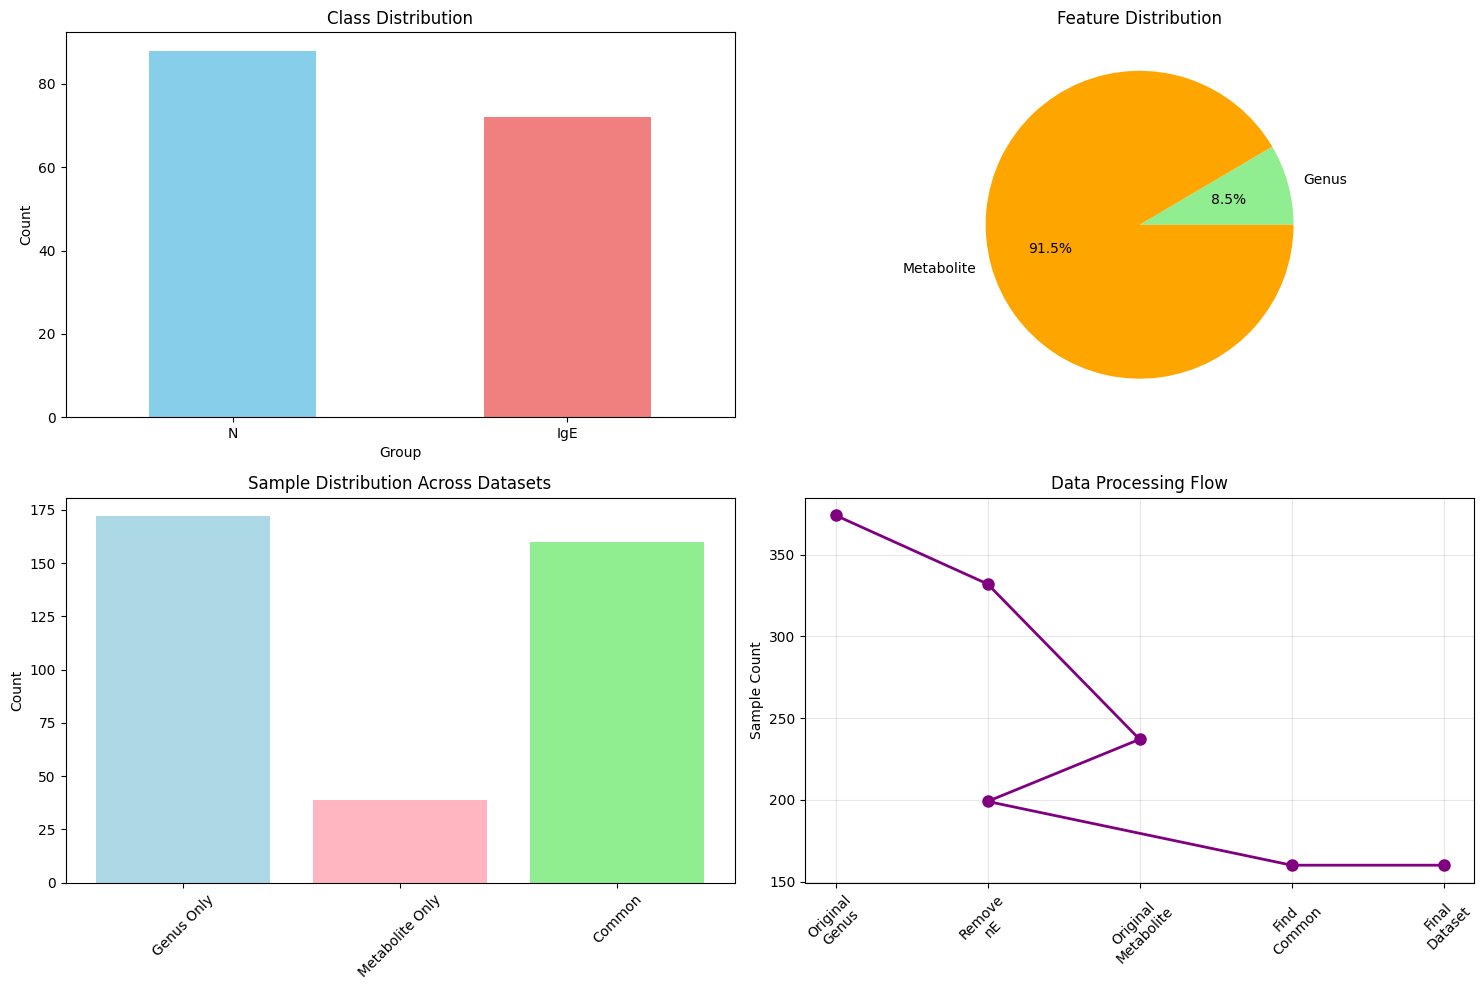


Visualization saved as 'data_processing_summary.png'


In [15]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class distribution
groups.value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Class Distribution')
axes[0,0].set_xlabel('Group')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Feature distribution (genus vs metabolite)
feature_types = ['Genus', 'Metabolite']
feature_counts = [genus_common.shape[1], metabolite_common.shape[1]]
axes[0,1].pie(feature_counts, labels=feature_types, autopct='%1.1f%%', colors=['lightgreen', 'orange'])
axes[0,1].set_title('Feature Distribution')

# Sample distribution across datasets
sample_info = pd.DataFrame({
    'Dataset': ['Genus Only', 'Metabolite Only', 'Common'],
    'Count': [len(genus_only), len(metabolite_only), len(common_samples)]
})
axes[1,0].bar(sample_info['Dataset'], sample_info['Count'], color=['lightblue', 'lightpink', 'lightgreen'])
axes[1,0].set_title('Sample Distribution Across Datasets')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Data processing flow
steps = ['Original\nGenus', 'Remove\nnE', 'Original\nMetabolite', 'Remove\nnE', 'Find\nCommon', 'Final\nDataset']
counts = [genus_data.shape[1], genus_clean.shape[1], metabolite_data.shape[1], 
          metabolite_clean.shape[1], len(common_samples), combined_data.shape[0]]
axes[1,1].plot(steps, counts, marker='o', linewidth=2, markersize=8, color='purple')
axes[1,1].set_title('Data Processing Flow')
axes[1,1].set_ylabel('Sample Count')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data_processing_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'data_processing_summary.png'")

## 12. Prepare Data for Machine Learning

In [16]:
# Prepare data for machine learning
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(f"IgE: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"N: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"\nTest set class distribution:")
print(f"IgE: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"N: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")

# Save train/test splits
X_train.to_excel('X_train_genus_metabolite203.xlsx')
X_test.to_excel('X_test_genus_metabolite203.xlsx')
pd.DataFrame({'label': y_train}, index=X_train.index).to_excel('y_train_genus_metabolite203.xlsx')
pd.DataFrame({'label': y_test}, index=X_test.index).to_excel('y_test_genus_metabolite203.xlsx')

print("\nTrain/test splits saved!")

Training set: 128 samples
Test set: 32 samples

Training set class distribution:
IgE: 58 (45.3%)
N: 70 (54.7%)

Test set class distribution:
IgE: 14 (43.8%)
N: 18 (56.2%)

Train/test splits saved!


## Summary

This notebook has successfully:

1. **Loaded the data**: Genus data (tab-separated) and metabolite_203 data (Excel)
2. **Removed duplicates**: Eliminated nE samples from both datasets
3. **Found common samples**: Identified samples present in both datasets
4. **Created labels**: IgE = 1 (allergy positive), N = 0 (allergy negative)
5. **Combined datasets**: Merged genus and metabolite features
6. **Quality checks**: Verified data integrity
7. **Saved processed data**: Multiple output formats for further analysis
8. **Prepared ML data**: Train/test splits ready for modeling

The processed data is now ready for allergy prediction modeling!